In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as optim_ls
from tqdm import tqdm

In [2]:
DATA_DIR = "/Users/johnzhou/research/spike-sorting/data/"
OUT_DIR = "/Users/johnzhou/research/spike-sorting/output/"
TOTAL_NUM_CHANNELS = 384 # Neuropixels 2.0 probe

### Plot the waveform templates for visual inspection and remove bad templates

In [3]:
def get_max_chan_temps(templates):
    return templates.ptp(1).argmax(1)

def get_argmin_ptp(templates, max_chan_temp):
    argmin_ptp = np.zeros(templates.shape[0])
    for i in range(templates.shape[0]):
        argmin_ptp[i] = templates[i, :, max_chan_temp[i]].argmin()
        
def plot_templates(templates, max_chan_temp, n_channels=20):
    for i in range(templates.shape[0]):
        print(i)
        plt.figure(figsize = (n_channels, 2.5))
        plt.plot(templates[i, :80, max_chan_temp[i]-n_channels//2:max_chan_temp[i]+n_channels//2].T.flatten())
        for j in range(19):
            plt.axvline(80 + 80*j, color = 'black')
        plt.show()

### Get the 10 templates above and below the channel with max ptp

In [4]:
def take_channel_range(templates, n_channels_loc=20):
    templates_chans = np.zeros((templates.shape[0], templates.shape[1], n_channels_loc))
    templates_chans_ptp = np.zeros((templates.shape[0], n_channels_loc))

    for i in range(templates.shape[0]):
        mc = templates[i].ptp(0).argmax()
        if mc <= n_channels_loc // 2:
            channels_wfs = np.arange(0, n_channels_loc)
        elif mc > TOTAL_NUM_CHANNELS - n_channels_loc:
            channels_wfs = np.arange(TOTAL_NUM_CHANNELS - n_channels_loc, TOTAL_NUM_CHANNELS)
        else:
            up_or_down = templates[i].ptp(0)[mc+2] > templates[i].ptp(0)[mc-2]
            if up_or_down and mc%2 == 0:
                channels_wfs = np.arange(mc - n_channels_loc//2 + 2, mc + n_channels_loc//2 + 2)
            elif up_or_down:
                channels_wfs = np.arange(mc - n_channels_loc//2 + 1, mc + n_channels_loc//2 + 1)
            elif mc%2 == 1:
                channels_wfs = np.arange(mc - n_channels_loc//2 - 1, mc + n_channels_loc//2 - 1)
            else:
                channels_wfs = np.arange(mc - n_channels_loc//2, mc + n_channels_loc//2)
        templates_chans[i] = templates[i,:,channels_wfs].T
        templates_chans_ptp[i] = templates[i,:,channels_wfs].T.ptp(0)

    return templates_chans, templates_chans_ptp

### Estimate positions of templates

In [5]:
def minimize_ls(vec, ptps, channels_pos):
    return (ptps-vec[3]/(((channels_pos - [vec[0], vec[1]])**2).sum(1) + vec[2]**2)**0.5) #**2).sum()

def minimize_ls_bis(vec, ptps, channels_pos):
    return ptps*(((channels_pos - [vec[0], vec[1]])**2).sum(1) + vec[2]**2)**0.5-vec[3] 

def minimize_summed(vec, ptps, channels_pos):
    return ((ptps-vec[3]/(((channels_pos - [vec[0], vec[1]])**2).sum(1) + vec[2]**2)**0.5)**2).sum()

def minimize_de(vec, ptps, channels_pos):
    return (ptps*(((channels_pos - [vec[0], vec[1]])**2).sum(1)+400)**0.5-vec[3]).mean()

def localize_wfs(waveforms_ptp, geom_array):
    n_temp = waveforms_ptp.shape[0]
    output = np.zeros((n_temp, 4))
    channels_pos = geom_array[:waveforms_ptp.shape[1]]
    for i in tqdm(range(n_temp)):
        y_init = 22
        z_com = (waveforms_ptp[i]*channels_pos[:, 1]).sum()/waveforms_ptp[i].sum()
        x_com = (waveforms_ptp[i]*channels_pos[:, 0]).sum()/waveforms_ptp[i].sum()
        alpha_init = waveforms_ptp[i].max()*((((channels_pos - [x_com, z_com])**2).sum(1).min()+y_init**2)**0.5)
        output[i] = optim_ls.least_squares(minimize_ls, x0=[x_com, z_com, y_init, alpha_init], bounds = ([-150, -200, 0, 0], [182, 200, np.max([y_init+10, 150]), np.max([alpha_init+10, 10000])]), 
                                           args=(waveforms_ptp[i], channels_pos), tr_solver='exact')['x']
    return output

### Project templates to new locations

In [60]:
channels_pos[:, 1].mean()
print(channels_pos)

[[  0.   0.]
 [ 32.   0.]
 [  0.  15.]
 [ 32.  15.]
 [  0.  30.]
 [ 32.  30.]
 [  0.  45.]
 [ 32.  45.]
 [  0.  60.]
 [ 32.  60.]
 [  0.  75.]
 [ 32.  75.]
 [  0.  90.]
 [ 32.  90.]
 [  0. 105.]
 [ 32. 105.]
 [  0. 120.]
 [ 32. 120.]
 [  0. 135.]
 [ 32. 135.]]


In [6]:
def relocate_templates(templates, positions_templates, channels_pos, a, loc, scale, size, n_samples = 50):
    gamma = stats.gamma
    y = gamma.rvs(a, loc, scale, size=size)
    
    chan_pos_mean = channels_pos[:, 1].mean()
    new_templates = np.zeros((n_samples, templates.shape[1], templates.shape[2]))
    alpha = gamma.rvs(a, loc, scale, size=n_samples)
    y = np.random.uniform(0, 150, n_samples)
    x_z = np.zeros((2, n_samples))
    x_z[0, :] = np.random.uniform(-150, 182, n_samples)
    x_z[1, :] = np.random.normal(chan_pos_mean, 25, n_samples)
    idxbool = (y**2 + (x_z[0, :]-16)**2 > 150**2)
    num_outside = idxbool.sum()
    while num_outside > 0:
        y[idxbool] = np.random.uniform(0, 150, num_outside)
        x_z[0, idxbool] = np.random.uniform(-150, 182, num_outside)
        idxbool = (y**2 + (x_z[0, :]-16)**2 > 150**2)
        num_outside = idxbool.sum()
    relocated_positions = np.zeros((4, n_samples))
    relocated_positions[:2] = x_z
    relocated_positions[2] = y
    relocated_positions[3] = alpha
    idx_units = np.zeros(n_samples)
    for i in tqdm(range(n_samples)):
        idx_temp = np.random.choice(np.arange(positions_templates.shape[0]))
        idx_units[i] = idx_temp
        # scaling_factor = np.random.uniform(0.8, 1.5)
        for j in range(channels_pos.shape[0]):
            predicted_ptp = positions_templates[idx_temp, 3]/((([positions_templates[idx_temp, 0],
                                                                 positions_templates[idx_temp, 1]] - 
                                                                channels_pos[j])**2).sum() + 
                                                              positions_templates[idx_temp, 2]**2)**0.5
            new_predicted_ptp = alpha[i]/(((x_z[:,i]-channels_pos[j])**2).sum() + y[i]**2)**0.5
            new_templates[i, :, j] = templates[idx_temp, :, j]*new_predicted_ptp/predicted_ptp
    return new_templates, new_templates.ptp(1), relocated_positions, idx_units

### Center templates at the same time point

In [7]:
def time_center_templates(templates_chans):
    centered_templates = np.zeros(templates_chans.shape)
    for i in range(templates_chans.shape[0]):
        mc = templates_chans[i].ptp(0).argmax()
        offset = 42 - templates_chans[i, :, mc].argmin()
        centered_templates[i] = np.roll(templates_chans[i], offset, axis = 0)
    return centered_templates

### Identify bad templates and remove them

In [45]:
templates_fname = "templates_yass.npy"
templates_fpath = os.path.join(DATA_DIR, templates_fname)
templates = np.load(templates_fpath)
geom_fname = "np2_channel_map.npy"
geom_fpath = os.path.join(DATA_DIR, geom_fname)
geom_array = np.load(geom_fpath)
channels_pos = geom_array[:20]

bad_template_idxs = [3, 6, 27, 29, 32, 35, 36, 56, 57, 58, 59, 62, 63, 64, 74, 78, 79, 80, 85, 91, 92, \
    101, 107, 109, 110, 111, 118, 119, 121, 145, 150, 151, 152, 157, 159, 164, 165, 169]
templates = np.delete(templates, bad_template_idxs, axis=0)

a, loc, scale = 3, 100, 500
size = 20000
n_samples = 100000
n_channels = 20

num_templates, duration, num_channels = templates.shape
print("{} contains {} templates for {} timesteps across {} channels.".format(
    templates_fname, num_templates, duration, num_channels))
max_chan_temp = get_max_chan_temps(templates)
# plot_templates(templates, max_chan_temp, n_channels=20)

templates_yass.npy contains 132 templates for 121 timesteps across 384 channels.


In [46]:
templates_fname = "templates_yass.npy"
templates_fpath = os.path.join(DATA_DIR, templates_fname)
templates = np.load(templates_fpath)
geom_fname = "np2_channel_map.npy"
geom_fpath = os.path.join(DATA_DIR, geom_fname)
geom_array = np.load(geom_fpath)
channels_pos = geom_array[:20]

a, loc, scale = 3, 100, 500
size = 20000
n_samples = 2000
n_channels = 20

num_templates, duration, num_channels = templates.shape
print("{} contains {} templates for {} timesteps across {} channels.".format(
    templates_fname, num_templates, duration, num_channels))

# Manually identify and remove bad templates from plots
bad_template_idxs = [3, 6, 27, 29, 32, 35, 36, 56, 57, 58, 59, 62, 63, 64, 74, 78, 79, 80, 85, 91, 92, \
    101, 107, 109, 110, 111, 118, 119, 121, 145, 150, 151, 152, 157, 159, 164, 165, 169]
good_templates = np.delete(templates, bad_template_idxs, axis=0)
print("Removed {} bad templates, {} remaining.".format(len(bad_template_idxs), good_templates.shape[0]))

templates_yass.npy contains 170 templates for 121 timesteps across 384 channels.
Removed 38 bad templates, 132 remaining.


### Produce relocated template samples

In [47]:
templates_chans, templates_ptp_chans = take_channel_range(good_templates, n_channels_loc=n_channels)
positions_templates = localize_wfs(templates_ptp_chans, geom_array)
reloc_templates, reloc_predicted_ptps, reloc_positions, idx_units = relocate_templates(
    templates_chans, positions_templates, channels_pos, a, loc, scale, size, n_samples=n_samples)

(132, 121, 384)
(20, 121, 384)


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2073.12it/s]


### Only 20 for clustering

In [48]:
good_templates_20_idxs = np.random.choice(good_templates.shape[0], size=20, replace=False)
good_templates_20 = np.take(good_templates, good_templates_20_idxs, axis=0)
print(good_templates_20.shape)
templates_chans, templates_ptp_chans = take_channel_range(good_templates_20, n_channels_loc=n_channels)
positions_templates = localize_wfs(templates_ptp_chans, geom_array)
cluster_templates, cluster_ptps, cluster_positions, cluster_idxs = relocate_templates(
    templates_chans, positions_templates, channels_pos, a, loc, scale, size, n_samples=n_samples)

(20, 121, 384)


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2194.92it/s]


In [17]:
print(templates_chans.shape)
print(templates_ptp_chans.shape)
print(positions_templates.shape)

(132, 121, 20)
(132, 20)
(132, 4)


### Center templates in time and normalize (non-Gaussian, but close enough)

In [11]:
reloc_templates = time_center_templates(reloc_templates)
mean = np.mean(reloc_templates, axis=(0, 1))
var = np.var(reloc_templates, axis=(0, 1))
reloc_templates = (reloc_templates - mean)/var
print(mean)
print(var)

[0.04532597 0.0417729  0.05575363 0.04711428 0.06507362 0.06171417
 0.07216927 0.07075539 0.0725675  0.07030476 0.07378275 0.06719783
 0.07967844 0.07267212 0.07498962 0.07843935 0.06696777 0.07227747
 0.05147127 0.06602478]
[ 6.60427169  5.68983479 10.28611111  9.58288021 15.72596326 16.86020701
 21.3376764  25.71765857 22.98559538 23.15998975 20.31592883 21.22664718
 19.75357132 22.78949473 15.11935463 19.73070697  9.97376448 14.20932605
  6.74788603  9.72577629]


### Plot relocated, normalized, and time-centered waveform samples

0


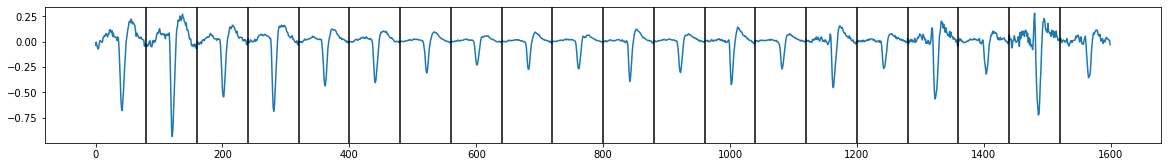

1


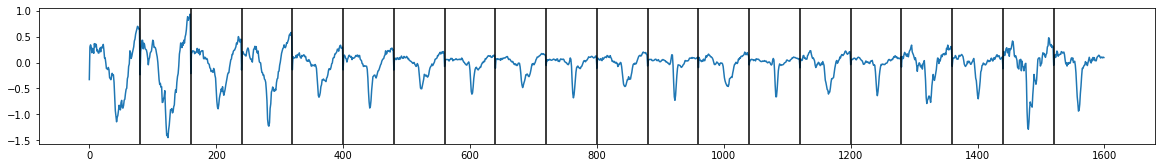

2


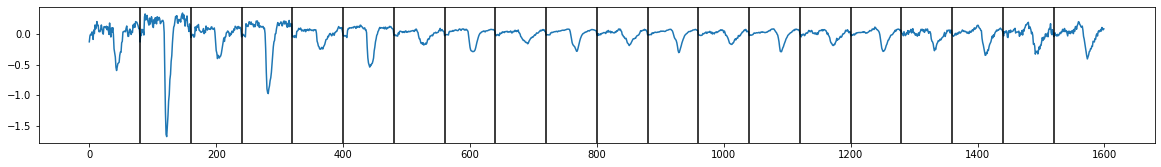

3


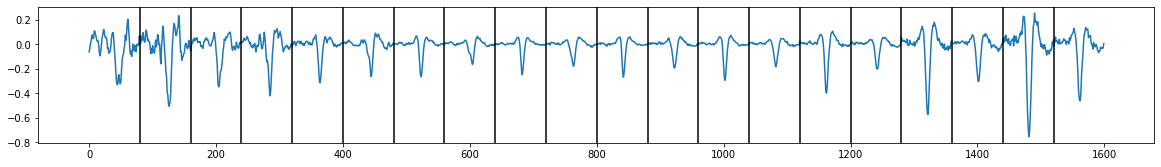

4


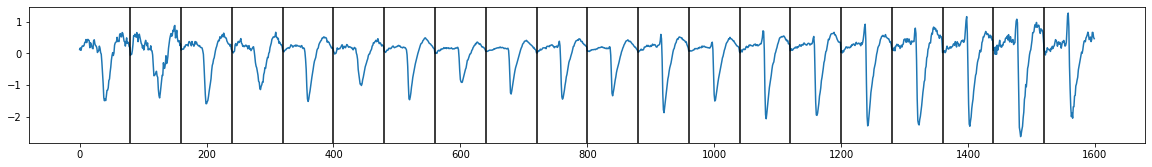

5


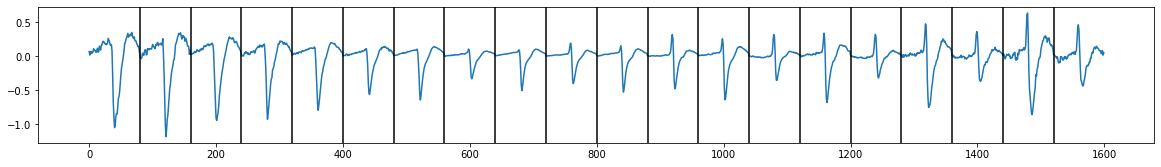

6


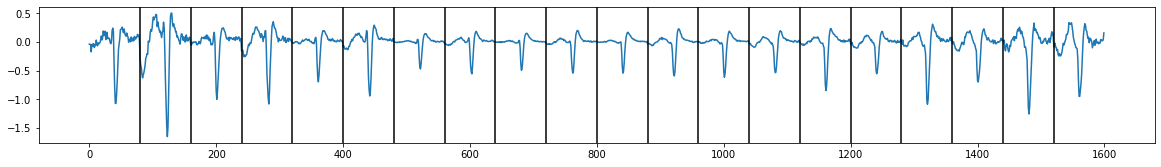

7


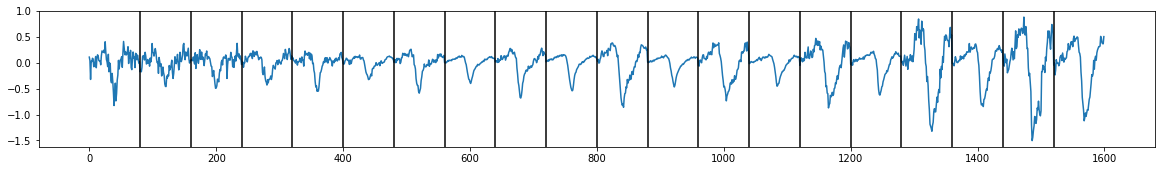

8


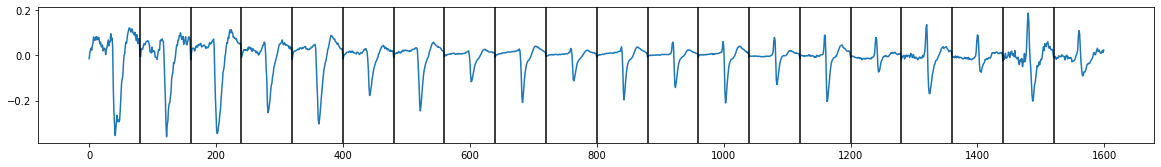

9


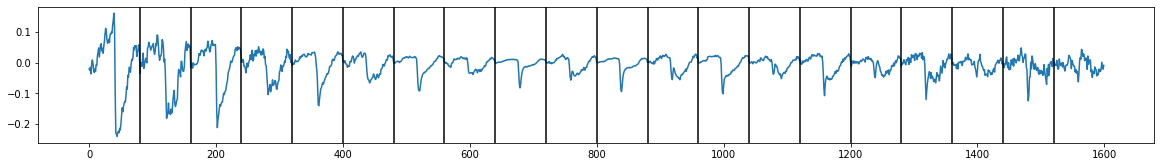

In [12]:
# for i in range(reloc_templates.shape[0]):
for i in range(10):
    print(i)
    plt.figure(figsize = (n_channels, 2.5))
    plt.plot(reloc_templates[i, :80, :].T.flatten())
    for j in range(19):
        plt.axvline(80 + 80*j, color = 'black')
    plt.show()

### Save templates, predicted ptps, positions, and indices of units - positions and predicted ptps for PS-VAE

In [25]:
training_dir = OUT_DIR + "training_data/"
print("Saving relocated templates, array of size: {}".format(reloc_templates.shape))
np.save("{}reloc_templates.npy".format(training_dir), reloc_templates)
print("Saving relocated templates' predicted PTPs, array of size: {}".format(reloc_predicted_ptps.shape))
np.save("{}reloc_templates_predicted_ptps.npy".format(training_dir), reloc_predicted_ptps)
print("Saving relocated templates' positions, array of size: {}".format(reloc_positions.shape))
np.save("{}reloc_templates_positions.npy".format(training_dir), reloc_positions)
print("Saving relocated templates' unit indices, array of size: {}".format(idx_units.shape))
np.save("{}reloc_templates_unit_idxs.npy".format(training_dir), idx_units)

Saving relocated templates (float), array of size: (100000, 121, 20)


### Generate templates with one perturbed feature

In [36]:
"""templates parameter should just be one template to keep everything except perturbed feature constant"""
def relocate_templates_1d(templates, positions_templates, channels_pos, a, loc, scale, 
                       size, pert_feat="x", n_samples=100):
    
    gamma = stats.gamma
    if pert_feat != "alpha":
        alpha_const = gamma.rvs(a, loc, scale)
        alpha = np.full(n_samples, alpha_const)
    else:
        alpha = gamma.rvs(a, loc, scale, size=n_samples)

    chan_pos_mean = channels_pos[:, 1].mean()
    
    new_templates = np.zeros((n_samples, templates.shape[1], templates.shape[2]))
    
    if pert_feat != "y":
        y_const = np.random.uniform(0, 150)
        y = np.full(n_samples, y_const)
    else:
        y = np.random.uniform(0, 150, n_samples)
    
    x_z = np.zeros((2, n_samples))
    
    if pert_feat != "x":
        x_const = np.random.uniform(-150, 182)
        x_z[0, :] = np.full(n_samples, x_const)
    else:
        x_z[0, :] = np.random.uniform(-150, 182, n_samples)
        
    if pert_feat != "z":
        z_const = np.random.normal(chan_pos_mean, 25)
        x_z[1, :] = np.full(n_samples, z_const)
    else:
        x_z[1, :] = np.random.normal(chan_pos_mean, 25, n_samples)
        
    idxbool = (y**2 + (x_z[0, :]-16)**2 > 150**2)
    num_outside = idxbool.sum()
    while num_outside > 0:
        if pert_feat != "y":
            y_const = np.random.uniform(0, 150)
            y = np.full(n_samples, y_const)
        else:
            y[idxbool] = np.random.uniform(0, 150, num_outside)
        if pert_feat != "x":
            x_const = np.random.uniform(-150, 182)
            x_z[0, :] = np.full(n_samples, x_const)
        else:
            x_z[0, idxbool] = np.random.uniform(-150, 182, num_outside)
        idxbool = (y**2 + (x_z[0, :]-16)**2 > 150**2)
        num_outside = idxbool.sum()
    relocated_positions = np.zeros((4, n_samples))
    relocated_positions[:2] = x_z
    relocated_positions[2] = y
    relocated_positions[3] = alpha
    idx_units = np.zeros(n_samples)
    for i in tqdm(range(n_samples)):
        idx_temp = np.random.choice(np.arange(positions_templates.shape[0]))
        idx_units[i] = idx_temp
        for j in range(channels_pos.shape[0]):
            predicted_ptp = positions_templates[idx_temp, 3]/((([positions_templates[idx_temp, 0],
                                                                 positions_templates[idx_temp, 1]] - 
                                                                channels_pos[j])**2).sum() + 
                                                              positions_templates[idx_temp, 2]**2)**0.5
            new_predicted_ptp = alpha[i]/(((x_z[:,i]-channels_pos[j])**2).sum() + y[i]**2)**0.5
            new_templates[i, :, j] = templates[idx_temp, :, j]*new_predicted_ptp/predicted_ptp
    return new_templates, new_templates.ptp(1), relocated_positions, idx_units

In [ ]:
# Produce relocated templates with perturbed feature
num_neurons = 1
perturb_feature = "x"
num_good_templates = good_templates.shape[0]
neuron_template_idxs = [45] # np.random.choice(num_good_templates, size=num_neurons, replace=False)
neuron_templates = np.take(good_templates, neuron_template_idxs, axis=0)
templates_chans, templates_ptp_chans = take_channel_range(neuron_templates, n_channels_loc=n_channels)
positions_templates = localize_wfs(templates_ptp_chans, geom_array)
reloc_templates, reloc_predicted_ptps, reloc_positions, idx_units = relocate_templates_1d(
    templates_chans, positions_templates, channels_pos, a, loc, scale, size, pert_feat=perturb_feature)
print(reloc_templates.shape)
print(reloc_predicted_ptps.shape)
print(reloc_positions.shape)
print(idx_units.shape)
print(reloc_positions[0, :10])

# Time center and z-score
reloc_templates = time_center_templates(reloc_templates)
mean = np.mean(reloc_templates, axis=(0, 1))
var = np.var(reloc_templates, axis=(0, 1))
reloc_templates = (reloc_templates - mean)/var
print(mean)
print(var)

In [ ]:
# Save information
training_dir = OUT_DIR + "training_data/"
print("Saving relocated templates, array of size: {}".format(reloc_templates.shape))
np.save("{}og_templates_{}_vary.npy".format(training_dir, perturb_feature), reloc_templates)
print("Saving relocated templates' predicted PTPs, array of size: {}".format(reloc_predicted_ptps.shape))
np.save("{}reloc_templates_predicted_ptps_{}_vary.npy".format(training_dir, perturb_feature), reloc_predicted_ptps)
print("Saving relocated templates' positions, array of size: {}".format(reloc_positions.shape))
np.save("{}reloc_templates_positions_{}_vary.npy".format(training_dir, perturb_feature), reloc_positions)
print("Saving relocated templates' unit indices, array of size: {}".format(idx_units.shape))
np.save("{}reloc_templates_unit_idxs_{}_vary.npy".format(training_dir, perturb_feature), idx_units)

### Generate cluster data

In [56]:
"""templates parameter should just be one template to keep everything except perturbed feature constant"""
def generate_cluster_samples(templates, positions_templates, channels_pos, a, loc, scale, size, 
                             n_clusters=20, n_samples_per=100):
    gamma = stats.gamma
    
    chan_pos_mean = channels_pos[:, 1].mean()
    new_templates = np.zeros((n_clusters * n_samples_per, templates.shape[1], templates.shape[2]))
    
    # For each cluster, randomly select a template and mean position
    mean_alpha = gamma.rvs(a, loc, scale, size=n_clusters)
    mean_x_z = np.zeros((2, n_clusters))
    mean_x_z[0, :] = np.random.uniform(-150, 182, n_clusters)
    mean_x_z[1, :] = np.random.normal(chan_pos_mean, 25, n_clusters)
    mean_y = np.random.uniform(0, 150, n_clusters)
    
    idxbool = (mean_y**2 + (mean_x_z[0, :]-16)**2 > 150**2)
    num_outside = idxbool.sum()
    while num_outside > 0:
        mean_y[idxbool] = np.random.uniform(0, 150, num_outside)
        mean_x_z[0, idxbool] = np.random.uniform(-150, 182, num_outside)
        idxbool = (mean_y**2 + (mean_x_z[0, :]-16)**2 > 150**2)
        num_outside = idxbool.sum()
        
    # Now repeat each mean by the number of samples desired per
    mean_alpha = np.repeat(mean_alpha, n_samples_per)
    mean_x_z = np.repeat(mean_x_z, n_samples_per, axis=1)
    mean_y = np.repeat(mean_y, n_samples_per)
    
    # Apply "drift" for every sample
    alpha = np.random.normal(mean_alpha, 200)
    x_z = np.random.normal(mean_x_z, 20)
    y = np.random.normal(mean_y, 20)
    
    relocated_positions = np.zeros((4, n_clusters * n_samples_per))
    relocated_positions[:2] = x_z
    relocated_positions[2] = y
    relocated_positions[3] = alpha
    idx_units = np.zeros(n_samples_per * n_clusters)
    i = 0
    idx_temps = np.random.choice(np.arange(positions_templates.shape[0]), size=n_clusters, replace=False)
    for k in range(n_clusters):
        idx_temp = idx_temps[k]
        for j in range(n_samples_per):
            idx_units[i] = idx_temp
            # scaling_factor = np.random.uniform(0.8, 1.5)
            for j in range(channels_pos.shape[0]):
                predicted_ptp = positions_templates[idx_temp, 3]/((([positions_templates[idx_temp, 0],
                                                                     positions_templates[idx_temp, 1]] - 
                                                                    channels_pos[j])**2).sum() + 
                                                                  positions_templates[idx_temp, 2]**2)**0.5
                new_predicted_ptp = alpha[i]/(((x_z[:,i]-channels_pos[j])**2).sum() + y[i]**2)**0.5
                new_templates[i, :, j] = templates[idx_temp, :, j]*new_predicted_ptp/predicted_ptp
            i += 1
        print("{} clluster done".format(k))
    print("done")
    return new_templates, new_templates.ptp(1), relocated_positions, idx_units

In [57]:
num_clusters = 20
cluster_templates, cluster_ptps, cluster_positions, cluster_idxs = generate_cluster_samples(
    templates_chans, positions_templates, channels_pos, a, loc, scale, size, n_clusters=num_clusters, n_samples_per=100)
# reloc_templates, reloc_predicted_ptps, reloc_positions, idx_units = relocate_templates(
#     templates_chans, positions_templates, channels_pos, a, loc, scale, size, n_samples=n_samples)

0 clluster done
1 clluster done
2 clluster done
3 clluster done
4 clluster done
5 clluster done
6 clluster done
7 clluster done
8 clluster done
9 clluster done
10 clluster done
11 clluster done
12 clluster done
13 clluster done
14 clluster done
15 clluster done
16 clluster done
17 clluster done
18 clluster done
19 clluster done
done


In [58]:
print(cluster_templates.shape)
print(cluster_ptps.shape)
print(cluster_positions.shape)
print(cluster_idxs.shape)
# Save information
training_dir = OUT_DIR + "training_data/"
print("Saving cluster templates, array of size: {}".format(cluster_templates.shape))
np.save("{}{}_cluster_templates.npy".format(training_dir, num_clusters), cluster_templates)
print("Saving relocated templates' predicted PTPs, array of size: {}".format(cluster_ptps.shape))
np.save("{}{}_cluster_predicted_ptps.npy".format(training_dir, num_clusters), cluster_ptps)
print("Saving relocated templates' positions, array of size: {}".format(cluster_positions.shape))
np.save("{}{}_cluster_positions.npy".format(training_dir, num_clusters), cluster_positions)
print("Saving relocated templates' unit indices, array of size: {}".format(cluster_idxs.shape))
np.save("{}{}_cluster_unit_idxs.npy".format(training_dir, num_clusters), cluster_idxs)

(2000, 121, 20)
(2000, 20)
(4, 2000)
(2000,)
Saving cluster templates, array of size: (2000, 121, 20)
Saving relocated templates' predicted PTPs, array of size: (2000, 20)
Saving relocated templates' positions, array of size: (4, 2000)
Saving relocated templates' unit indices, array of size: (2000,)
